In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

## The Upper Confidence Bound (UCB) Algorithm

As we've seen, Epsilon-Greedy has linear regret. It continues to explore the set of all actions, long after it has gained sufficient knowledge to know which of these actions are bad actions to take.

A better approach, in terms of maximising the total reward, would be to restrict the sampling over time, to the actions showing the best performance. This is the exact approach taken by the Upper Confidence Bound (UCB) strategy.

Rather than performing exploration by simply selecting an arbitrary action, chosen with a probability that remains constant, the UCB algorithm changes its exploration-exploitation balance as it gathers more knowledge of the environment. It moves from being primarily focused on exploration, when actions that have been tried the least are preferred, to instead concentrate on exploitation, selecting the action with the highest estimated reward.

With UCB, 'Aₜ', the action chosen at time step 't', is given by:


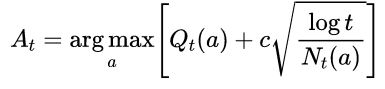


where;
Qₜ(a) is the estimated value of action 'a' at time step 't'.
Nₜ(a) is the number of times that action 'a' has been selected, prior to time 't'.
'c' is a constant, whose role will be described shortly.



The formula for UCB can be thought of as being formed from 2 distinct parts:

* Qₜ(a) represents the exploitation part of the equation. UCB is based on the principle of "optimism in the fact of uncertainty", which basically means, if you don't know which action is best then choose the one that currently looks to be the best. Taking this half of the equation by itself will do exactly that: the action that currently has the highest estimated reward will be the chosen action.


* The second half of the equation adds exploration, with the degree of exploration being controlled by the hyper-parameter 'c'. Effectively this term provides a measure of the uncertainty for the action's reward estimate.
If an action hasn't been tried very often, or not at all, then Nₜ(a) will be small. Consequently the uncertainty term will be large, making this action more likely to be selected. Every time an action is taken, we become more confident about its estimate. In this case Nₜ(a) increments, and so the uncertainty term decreases, making it less likely that this action will be selected as a result of exploration (although it may still be selected as the action with the highest value, due to the exploitation term).
When an action is not being selected, the uncertainty term will grow slowly, due to the log function in the numerator. Whereas, every time that the action is selected, the uncertainty will shrink rapidly due to the increase in Nₜ(a) being linear. So the exploration term will be larger for actions that have been selected infrequently, due to the uncertainty in the estimates of their rewards.
As time progresses the exploration term gradually decreases (since as 'n' goes to infinity log n/n goes to zero), until eventually actions are selected based only on the exploitation term.

The relative contributions of each of the exploration and exploitation terms can be seen in the graph below. Here, to simplify the comparison, we've taken only the first 2 sockets from our standard set. These 2 sockets have mean reward values of 6 and 4 seconds of charge respectively and it can be seen as time progresses that the estimate of the reward (the Q value, shown by the shaded bars) converges on this value for each socket.

But the UCB formula also contains the uncertainty term, represented by the solid part of the bar for each socket, and the socket that gets selected is the one with the maximum value of Q plus this uncertainty term. So, on the graph, at each time step, the socket that will be selected is the one with tallest bar.

In [2]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):    
        """ initialize the UCB socket """                  
        
        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)       
                
        # pass the true reward value to the base PowerSocket   
        super().__init__(q)           
        
    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 
        

In [9]:
class UCBSocketTester( SocketTester ):

    def __init__(self, socket_order, confidence_level=2.0 ):                  
        """ initialize the socket tester """                  
        super().__init__(socket = UCBSocket, 
                         socket_order = socket_order, 
                         confidence_level = confidence_level, 
                         number_of_stats = 3) # a UCB socket tester records 3 bits of information over a run
        
    def get_socket_stats( self, t ):
        """ record the current values of each socket """
        socket_stats = [[socket.Q,socket.n,socket.uncertainty(t+1)] for socket in self.sockets]
        return socket_stats   

    def select_socket( self, t ):
        """ choose the socket with the current highest UCB reward """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])     
        return socket_index        

In [10]:
# do a single run with only 2 sockets to examine how the exploration and exploitation terms of the UCB equation vary
c = 3.0
number_of_sockets = 2
number_of_steps = 20
tester = UCBSocketTester( socket_order[:number_of_sockets], c )
tester.run( number_of_steps )

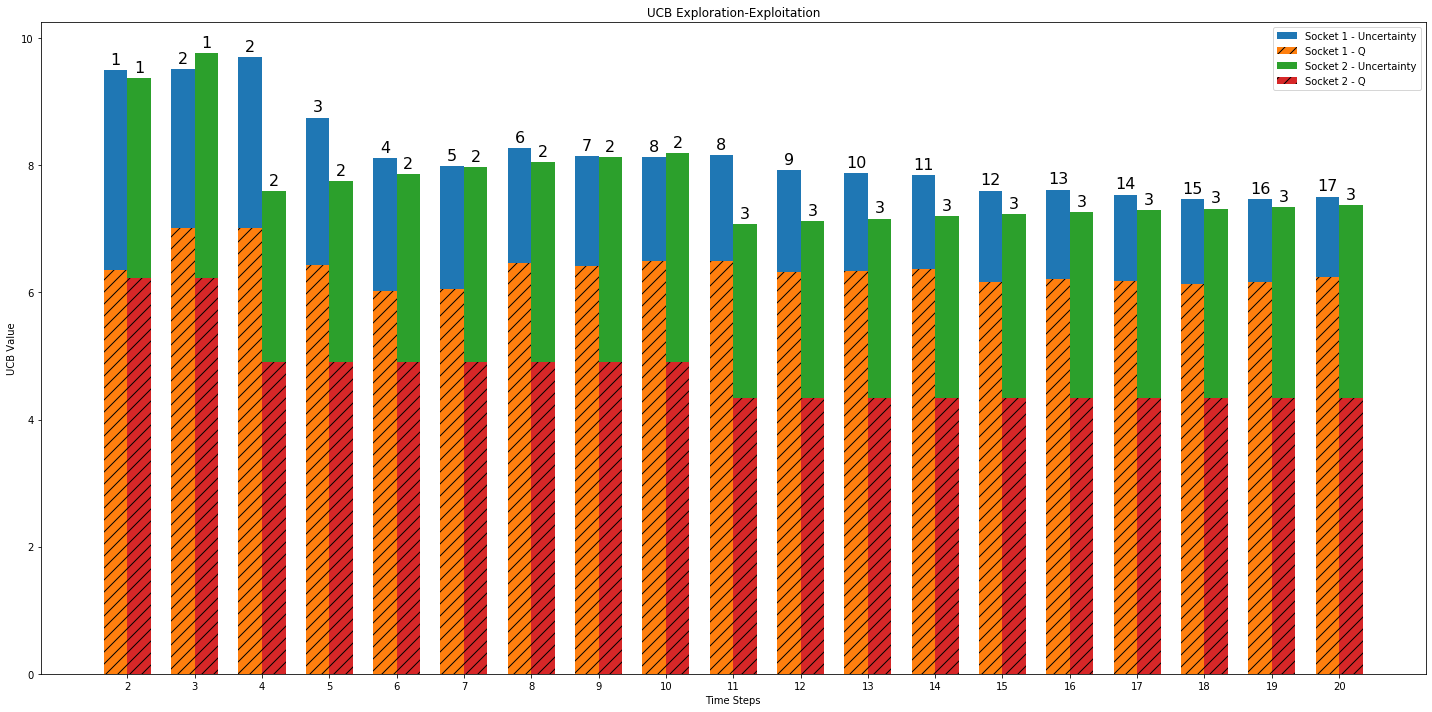

In [11]:
# get the parameters to graph from the socket stats
estimates = tester.socket_stats[:,:,0]
trials = tester.socket_stats[:,:,1]
uncertainty = tester.socket_stats[:,:,2]

x = np.arange(len(estimates[:,0]))[2:]  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = [ plt.bar(x, uncertainty[2:,0]+estimates[2:,0], align='edge', width= -width, label='Socket 1 - Uncertainty'),
           plt.bar(x, estimates[2:,0], align='edge', width= -width, label='Socket 1 - Q', hatch='//')]

rects2 = [ plt.bar(x, uncertainty[2:,1]+estimates[2:,1], align='edge',width= width, label='Socket 2 - Uncertainty'),
           plt.bar(x, estimates[2:,1], align='edge',width= width, label='Socket 2 - Q', hatch='//')]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('UCB Value')
ax.set_xlabel('Time Steps')
ax.set_title('UCB Exploration-Exploitation')
ax.legend()
ax.set_xticks(x)


def autolabel(rects,index,trials):
    """Attach a text label above each bar in *rects*, displaying its number of trials"""

    for i,rect in enumerate(rects[0]):
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(trials[i+2,index]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    size=16,
                    ha='center', va='bottom')  


autolabel(rects1,0,trials)
autolabel(rects2,1,trials)

fig.tight_layout()

# plt.savefig('ucb_exploration_exploitation.png')
plt.show()